# **BLACK BOX MODEL DEFINITION**

In [ ]:
!pip install gdown
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2024-05-30 04:01:04--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-05-30 04:01:04 (82.1 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import json
import urllib.request
import numpy as np
import os
import torch.nn.functional as F
import pandas as pd

**Black box pytorch**

In [ ]:
class Bb_Models_pt():
    def __init__(self):
        self.bbmimg = models.mobilenet_v2(pretrained=True)
        self.bbmimg.eval()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bbmimg.to(self.device)
        self.preprocess_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        with open("imagenet_classes.txt", "r") as f:
          self.labels = [s.strip() for s in f.readlines()]


    def predict(self, image):
        image = torch.from_numpy(image).float()

        if image.dim() == 4 and image.shape[-1] == 3:
          batch = image.permute(0, 3, 1, 2)
        else:
          image = image.permute(2, 0, 1)
          batch = image.unsqueeze(0)

        batch = batch.to(self.device)
        self.bbmimg.eval()
        logits = self.bbmimg(batch)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()

    def predict_label(self, image,percen=True):
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)
        batch = image.unsqueeze(0)

        batch = batch.to(self.device)
        self.bbmimg.eval()
        logits = self.bbmimg(batch)
        probs = F.softmax(logits, dim=1)

        top_pred_idx = torch.argmax(probs, dim=1).item()
        class_name = self.labels[top_pred_idx]

        if percen:
          confidence = probs[0, top_pred_idx].item() * 100
          confidence = f"{confidence:.1f}%"
        else:
          confidence = probs[0, top_pred_idx].item()

        return class_name, confidence

    def get_image(self, path):
      with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
          img.convert('RGB')
          img_resized = img.resize((224, 224))
          img = np.array(img_resized)/255.0
          return img

Bb_model = Bb_Models_pt()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 35.7MB/s]


# **IMPLEMENTATION OF INTERPRETABILITY**

In [1]:
!pip install lime==0.2.0.1
!pip install scikit-image==0.22.0
!pip install kmedoids==0.5.0
!git clone https://github.com/ADMAntwerp/ImageCounterfactualExplanations.git
!git clone https://github.com/thutzr/GLIME-General-Stable-and-Local-LIME-Explanation.git
!mv GLIME-General-Stable-and-Local-LIME-Explanation glime
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!gdown --id 19V-ls2f7D3Ia7bLGrPVJkuSgiNitIMS2 -O sam.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=5266906e30adb49b2a69430a4861e35f54221734ce3af2b83b9decbc6301e1a3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 8.4 MB/s eta 0:00:00
Cloning into 'ImageCounterfactualExplanations'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 174 (delta 38), reused 164 (delta 28), pack-reused 0

In [ ]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
import sam
from skimage.segmentation import mark_boundaries

from lime import lime_image
from glime import lime_image as glime_image #
from ImageCounterfactualExplanations.isedc.sedc import sedc


import matplotlib.pyplot as plt



**Segment Anything Model**

In [ ]:
sam.initiate_sam("/content/sam_vit_h_4b8939.pth", "vit_h")

**Local Interpretable Model-agnostic Explanations**

In [ ]:
def LIME(img_path,bbfunt):
  img = bbfunt.get_image(img_path)
  plt.imshow(img)
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(img,
                                           bbfunt.predict, # classification function
                                           top_labels=5,
                                           hide_color=0,
                                           num_samples=1000) # number of images that will be sent to classification function

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
  binary_mask = (temp != 0).astype(int)
  image_explain = img * binary_mask

  return image_explain


**Segment Anything Model - Local Interpretable Model-agnostic Explanations**

In [ ]:
def SAM_LIME(img_path,bbfunt,sam):
  img = bbfunt.get_image(img_path)

  img_sam = Image.open(img_path).convert('RGB')
  img_sam = img_sam.resize((224, 224))
  img_sam = np.array(img_sam)
  common_mask = sam.SAM_segmentation_fn(img_sam)

  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(img,
                                          bbfunt.predict, # classification function
                                          top_labels=5,
                                          segmentation_fn=lambda x: common_mask,
                                          hide_color=0,
                                          num_samples=1000) # number of images that will be sent to classification function


  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
  binary_mask = (temp != 0).astype(int)
  image_explain = img * binary_mask

  return image_explain

**General Stable and Local LIME**

In [ ]:
def GLIME(img_path,bbfunt):
  img = bbfunt.get_image(img_path)
  explainer = glime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(img,
                                          bbfunt.predict, # classification function
                                          top_labels=5,
                                          hide_color=0,
                                          num_samples=1000) # number of images that will be sent to classification function

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
  binary_mask = (temp != 0).astype(int)
  image_explain = img * binary_mask

  return image_explain

**Segment Anything Model - General Stable and Local LIME**

In [ ]:
def SAM_GLIME(img_path,bbfunt,sam):
  img = bbfunt.get_image(img_path)

  img_sam = Image.open(img_path).convert('RGB')
  img_sam = img_sam.resize((224, 224))
  img_sam = np.array(img_sam)
  common_mask = sam.SAM_segmentation_fn(img_sam)

  explainer = glime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(img,
                                          bbfunt.predict, # classification function
                                          top_labels=5,
                                          segmentation_fn=lambda x: common_mask,
                                          hide_color=0,
                                          num_samples=1000) # number of images that will be sent to classification function

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
  binary_mask = (temp != 0).astype(int)
  image_explain = img * binary_mask

  return image_explain

**Search for Evidence Counterfactuals**

In [ ]:
def SEDC(img_path,bbfunt):
  img = bbfunt.get_image(img_path)

  segments = quickshift(img, kernel_size=4, max_dist=200, ratio=0.2)

  image_explain , segments_in_explanation, perturbation, new_class = sedc(img, bbfunt, segments, 'inpaint')
  return image_explain

**Segment Anything Model - Search for Evidence Counterfactuals**

In [ ]:
def SAM_SEDC(img_path,bbfunt,sam):
  img = bbfunt.get_image(img_path)

  img_sam = Image.open(img_path).convert('RGB')
  img_sam = img_sam.resize((224, 224))
  img_sam = np.array(img_sam)
  segments = sam.SAM_segmentation_fn(img_sam)

  image_explain , segments_in_explanation, perturbation, new_class = sedc(img, bbfunt, segments, 'inpaint')

  return image_explain

# **EXPERIMENTS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def ax_off(axs):
  axs.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
  axs.spines['top'].set_visible(False)
  axs.spines['right'].set_visible(False)
  axs.spines['left'].set_visible(False)
  axs.spines['bottom'].set_visible(False)

def ax_xlabel(axs,label_org_img,conf__org_img,label_ex,conf__ex,fz):
  axs.set_xlabel(f"ClassIO: {label_org_img} {conf__org_img} \n \n ClassIE: {label_ex} {conf__ex}", fontsize = fz)  #
  #axs[i, 0].xaxis.set_label_coords(0.5, -0.15)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

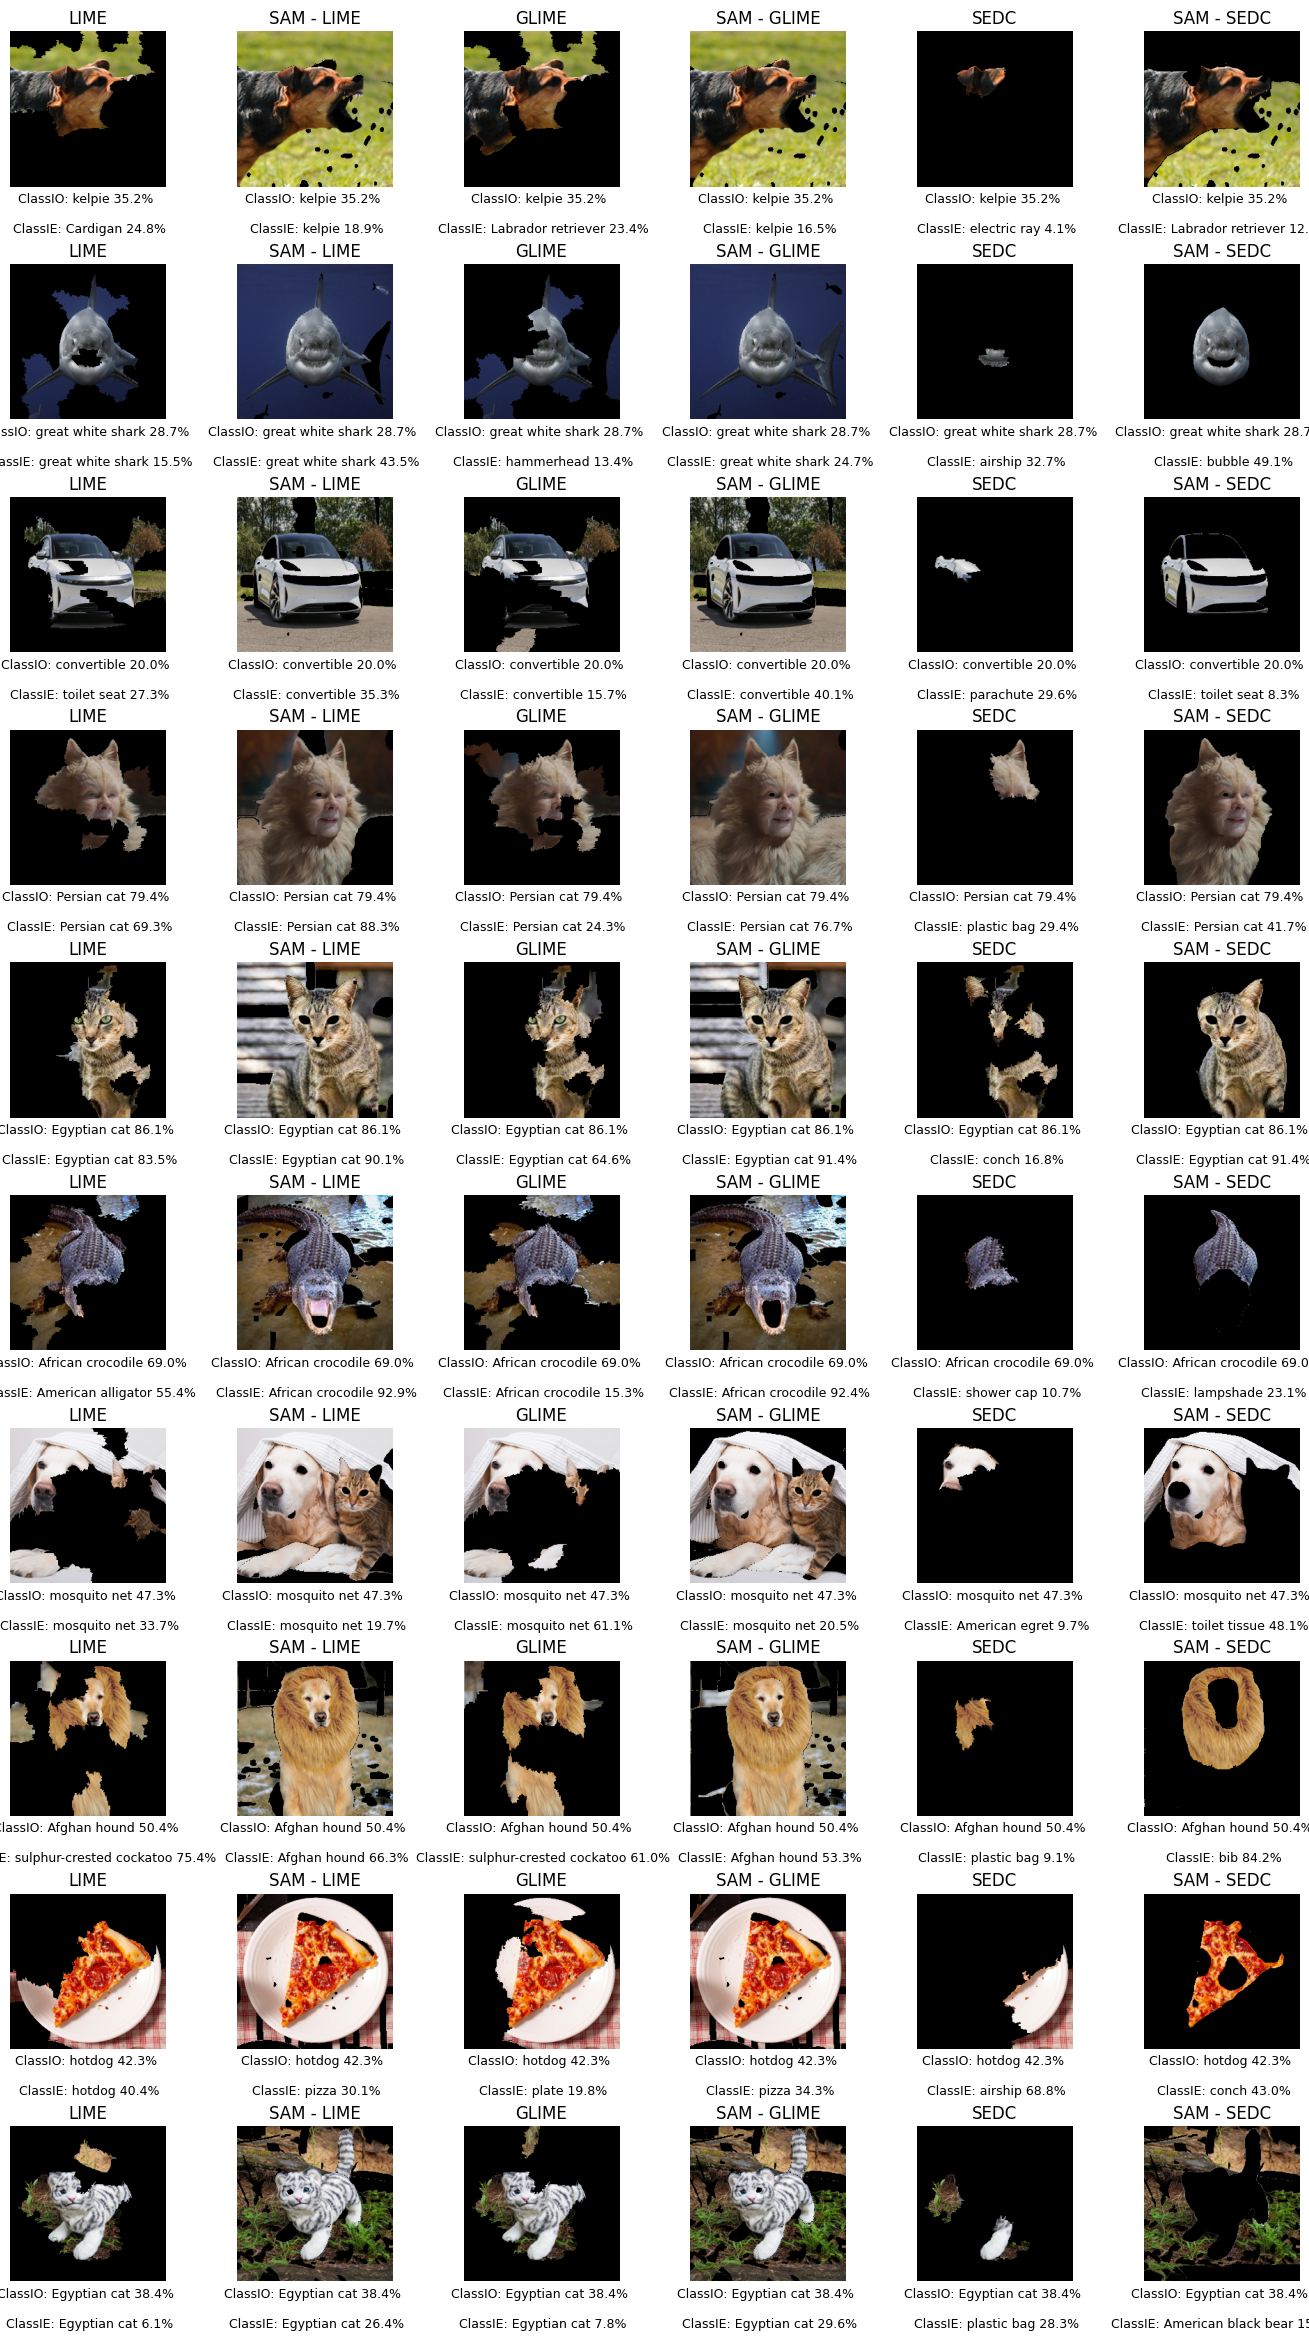

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 6, figsize=(15, 25))
fz=9

images_path = '/content/drive/MyDrive/XIA/IMAGES/'
file_names = os.listdir(images_path)

for i, file_name in enumerate(file_names):

  img_path = os.path.join(images_path, file_name)

  img_to_pred = Bb_model.get_image(img_path)
  label_org_img, confidence_org_img = Bb_model.predict_label(img_to_pred)


  # LIME
  lime_explain = LIME(img_path, Bb_model)

  axs[i, 0].imshow(lime_explain)
  axs[i, 0].set_title('LIME')
  #axs[i, 0].axis('off')

  label_org_img_lime, confidence_org_img_lime = Bb_model.predict_label(lime_explain)

  ax_xlabel(axs[i, 0],label_org_img,confidence_org_img,label_org_img_lime,confidence_org_img_lime,fz)
  ax_off(axs[i, 0])


  # SAM_LIME
  sam_lime_explain = SAM_LIME(img_path, Bb_model, sam)

  axs[i, 1].imshow(sam_lime_explain)
  axs[i, 1].set_title('SAM - LIME')

  label_org_img_lime_sam, confidence_org_img_lime_sam = Bb_model.predict_label(sam_lime_explain)

  ax_xlabel(axs[i, 1],label_org_img,confidence_org_img,label_org_img_lime_sam,confidence_org_img_lime_sam,fz)
  ax_off(axs[i, 1])


  # GLIME
  glime_explain = GLIME(img_path, Bb_model)

  axs[i, 2].imshow(glime_explain)
  axs[i, 2].set_title('GLIME')

  label_org_img_glime, confidence_org_img_glime = Bb_model.predict_label(glime_explain)

  ax_xlabel(axs[i, 2],label_org_img,confidence_org_img,label_org_img_glime,confidence_org_img_glime,fz)
  ax_off(axs[i, 2])


  # SAM GLIME
  sam_glime_explain = SAM_GLIME(img_path, Bb_model, sam)

  axs[i, 3].imshow(sam_glime_explain)
  axs[i, 3].set_title('SAM - GLIME')

  label_org_img_glime_sam, confidence_org_img_glime_sam= Bb_model.predict_label(sam_glime_explain)

  ax_xlabel(axs[i, 3],label_org_img,confidence_org_img,label_org_img_glime_sam,confidence_org_img_glime_sam,fz)
  ax_off(axs[i, 3])


  # SEDC
  sedc_explain = SEDC(img_path, Bb_model)

  axs[i, 4].imshow(sedc_explain)
  axs[i, 4].set_title('SEDC')

  label_org_img_sedc, confidence_org_img_sedc= Bb_model.predict_label(sedc_explain)

  ax_xlabel(axs[i, 4],label_org_img,confidence_org_img,label_org_img_sedc,confidence_org_img_sedc,fz)
  ax_off(axs[i, 4])


  # SAM SEDC
  sam_sedc_explain = SAM_SEDC(img_path, Bb_model,sam)

  axs[i, 5].imshow(sam_sedc_explain)
  axs[i, 5].set_title('SAM - SEDC')

  label_org_img_sedc_sam, confidence_org_img_sedc_sam= Bb_model.predict_label(sam_sedc_explain)

  ax_xlabel(axs[i, 5],label_org_img,confidence_org_img,label_org_img_sedc_sam,confidence_org_img_sedc_sam,fz)
  ax_off(axs[i, 5])


# Ajustar los espacios entre subplots y optimizar con tight_layout
plt.tight_layout(pad=1, w_pad=0.1, h_pad=1.5)  # Ajustar los parámetros de tight_layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.5)  # Reducir aún más hspace

plt.show()

#plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.5)


**Classification Consistency Index (CCI)**

The metric of the **Classification Consistency Index (CCI)** is defined as:
$$CCI = \delta(\text{label}_{\text{original}}, \text{label}_{\text{mask}}) \cdot e^{-|p_{\text{original}} - p_{\text{mask}}|}$$
where:
- $\delta(x,y)$ is the Kronecker delta function, which equals 1 if $x = y$ and 0 otherwise.
- $\text{label}_{\text{original}}$ and $\text{label}_{\text{mask}}$ are the labels predicted by the model before and after applying the mask, respectively.
- $p_{\text{original}}$ and $p_{\text{mask}}$ are the probabilities associated with these labels.



In [ ]:
def calculate_cci(original_confidence, mask_confidence,label_orgi,label_explain):
  delta = 1 if label_orgi == label_explain else 0
  return delta * np.exp(-abs(original_confidence - mask_confidence))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

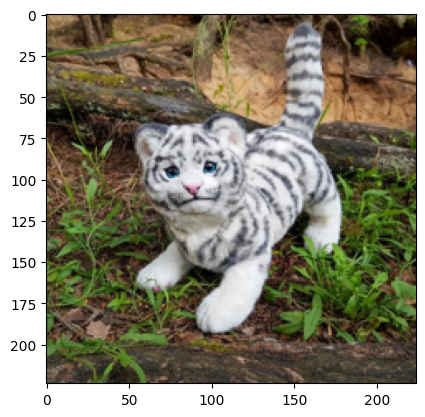

In [ ]:
input_images = ["Image 1", "Image 2", "Image 3", "Image 4", "Image 5",
              "Image 6", "Image 7", "Image 8", "Image 9", "Image 10", "Average"]

methods = ['LIME', 'SAM_LIME', 'GLIME', 'SAM_GLIME', 'SEDC', 'SAM_SEDC']

data = np.zeros((len(input_images), len(methods)))


images_path = '/content/drive/MyDrive/XIA/IMAGES/'
file_names = os.listdir(images_path)

for i, file_name in enumerate(file_names):

  img_path = os.path.join(images_path, file_name)

  img_to_pred = Bb_model.get_image(img_path)
  label_org_img, confidence_org_img = Bb_model.predict_label(img_to_pred,percen=False)


  # LIME
  lime_explain = LIME(img_path, Bb_model)
  label_org_img_lime, confidence_org_img_lime = Bb_model.predict_label(lime_explain,percen=False)
  lime_cci = calculate_cci(confidence_org_img, confidence_org_img_lime, label_org_img, label_org_img_lime)

  # SAM_LIME
  sam_lime_explain = SAM_LIME(img_path, Bb_model, sam)
  label_org_img_lime_sam, confidence_org_img_lime_sam = Bb_model.predict_label(sam_lime_explain,percen=False)
  sam_lime_cci = calculate_cci(confidence_org_img, confidence_org_img_lime_sam, label_org_img, label_org_img_lime_sam)

  # GLIME
  glime_explain = GLIME(img_path, Bb_model)
  label_org_img_glime, confidence_org_img_glime = Bb_model.predict_label(glime_explain,percen=False)
  glime_cci = calculate_cci(confidence_org_img, confidence_org_img_glime, label_org_img, label_org_img_glime)

  # SAM GLIME
  sam_glime_explain = SAM_GLIME(img_path, Bb_model, sam)
  label_org_img_glime_sam, confidence_org_img_glime_sam= Bb_model.predict_label(sam_glime_explain,percen=False)
  sam_glime_cci = calculate_cci(confidence_org_img, confidence_org_img_glime_sam, label_org_img, label_org_img_glime_sam)


  # SEDC
  sedc_explain = SEDC(img_path, Bb_model)
  label_org_img_sedc, confidence_org_img_sedc= Bb_model.predict_label(sedc_explain,percen=False)
  sedc_cci = calculate_cci(confidence_org_img, confidence_org_img_sedc, label_org_img, label_org_img_sedc)

  # SAM SEDC
  sam_sedc_explain = SAM_SEDC(img_path, Bb_model,sam)
  label_org_img_sedc_sam, confidence_org_img_sedc_sam= Bb_model.predict_label(sam_sedc_explain,percen=False)
  sam_sedc_cci = calculate_cci(confidence_org_img, confidence_org_img_sedc_sam, label_org_img, label_org_img_sedc_sam)

  data[i,:] = [lime_cci,sam_lime_cci,glime_cci,sam_glime_cci,sedc_cci,sam_sedc_cci]

average_cci = np.mean(data, axis=0)
new_data = np.vstack([data[:-1], average_cci])
df_icc = pd.DataFrame(new_data, index=input_images, columns=methods)


First test CCI

In [ ]:
print(df_icc)

              LIME  SAM_LIME     GLIME  SAM_GLIME  SEDC  SAM_SEDC
Image 1   0.000000  0.846159  0.000000   0.813275   0.0  0.000000
Image 2   0.000000  0.000000  0.000000   0.954762   0.0  0.000000
Image 3   0.000000  0.810945  0.000000   0.806967   0.0  0.000000
Image 4   0.506260  0.916082  0.000000   0.959229   0.0  0.685859
Image 5   0.519572  0.959694  0.749775   0.946788   0.0  0.948556
Image 6   0.000000  0.768628  0.598928   0.767992   0.0  0.000000
Image 7   0.000000  0.789233  0.943895   0.848387   0.0  0.000000
Image 8   0.917196  0.896462  0.000000   0.803277   0.0  0.000000
Image 9   0.854131  0.000000  0.761611   0.000000   0.0  0.000000
Image 10  0.739791  0.942828  0.821344   0.919970   0.0  0.000000
Average   0.321541  0.630003  0.352323   0.710968   0.0  0.148583


Second test CCI

In [ ]:
df_icc = pd.DataFrame(new_data, index=input_images, columns=methods)
print(df_icc)

              LIME  SAM_LIME     GLIME  SAM_GLIME  SEDC  SAM_SEDC
Image 1   0.000000  0.857651  0.000000   0.872817   0.0  0.000000
Image 2   0.000000  0.968632  0.000000   0.979852   0.0  0.000000
Image 3   0.000000  0.882907  0.923165   0.807248   0.0  0.000000
Image 4   0.724052  0.904547  0.675923   0.916082   0.0  0.685859
Image 5   0.545412  0.963001  0.664460   0.965090   0.0  0.948556
Image 6   0.000000  0.827606  0.000000   0.817533   0.0  0.000000
Image 7   0.744968  0.000000  0.900200   0.783796   0.0  0.000000
Image 8   0.766847  0.876957  0.996877   0.729172   0.0  0.000000
Image 9   0.948145  0.000000  0.000000   0.000000   0.0  0.000000
Image 10  0.000000  0.883157  0.731976   0.000000   0.0  0.000000
Average   0.339039  0.651314  0.444782   0.624690   0.0  0.148583


Third test CCI

In [ ]:
print(df_icc)

              LIME  SAM_LIME     GLIME  SAM_GLIME  SEDC  SAM_SEDC
Image 1   0.000000  0.885438  0.000000   0.839761   0.0  0.000000
Image 2   0.000000  0.000000  0.000000   0.963989   0.0  0.000000
Image 3   0.000000  0.835006  0.000000   0.828687   0.0  0.000000
Image 4   0.504515  0.959229  0.533246   0.963381   0.0  0.685859
Image 5   0.962748  0.975445  0.604847   0.930848   0.0  0.948556
Image 6   0.598928  0.779868  0.000000   0.810452   0.0  0.000000
Image 7   0.000000  0.818724  0.985344   0.772355   0.0  0.000000
Image 8   0.768412  0.775360  0.849877   0.842821   0.0  0.000000
Image 9   0.998645  0.000000  0.948145   0.000000   0.0  0.000000
Image 10  0.800657  0.948817  0.888898   0.969710   0.0  0.000000
Average   0.421264  0.634353  0.437305   0.720182   0.0  0.148583


Four test CCI

In [ ]:
print(df_icc)

              LIME  SAM_LIME     GLIME  SAM_GLIME  SEDC  SAM_SEDC
Image 1   0.858678  0.850585  0.000000   0.860889   0.0  0.000000
Image 2   0.000000  0.934392  0.000000   0.998791   0.0  0.000000
Image 3   0.000000  0.892287  0.941999   0.858602   0.0  0.000000
Image 4   0.575172  0.916082  0.572817   0.933223   0.0  0.685859
Image 5   0.598021  0.956177  0.749775   0.953409   0.0  0.948556
Image 6   0.000000  0.817556  0.000000   0.776677   0.0  0.000000
Image 7   0.875685  0.830282  0.985344   0.766960   0.0  0.000000
Image 8   0.926815  0.822797  0.000000   0.953271   0.0  0.000000
Image 9   0.948145  0.000000  0.908007   0.000000   0.0  0.000000
Image 10  0.726192  0.955718  0.724381   0.962434   0.0  0.000000
Average   0.500792  0.725080  0.443848   0.733114   0.0  0.148583


Five test CCI

In [ ]:
print(df_icc)

              LIME  SAM_LIME     GLIME  SAM_GLIME  SEDC  SAM_SEDC
Image 1   0.000000  0.899132  0.000000   0.911112   0.0  0.000000
Image 2   0.000000  0.000000  0.000000   0.885181   0.0  0.000000
Image 3   0.000000  0.867365  0.000000   0.832655   0.0  0.000000
Image 4   0.000000  0.959229  0.977331   0.933223   0.0  0.685859
Image 5   0.673272  0.975740  0.900038   0.954506   0.0  0.948556
Image 6   0.000000  0.889702  0.000000   0.875697   0.0  0.000000
Image 7   0.858276  0.831979  0.985344   0.756026   0.0  0.000000
Image 8   0.000000  0.942463  0.000000   0.839426   0.0  0.000000
Image 9   0.787477  0.000000  0.851120   0.000000   0.0  0.000000
Image 10  0.771558  0.954534  0.800657   0.768901   0.0  0.000000
Average   0.280962  0.665468  0.410408   0.705157   0.0  0.148583


Six test CCI

In [ ]:
print(df_icc)

              LIME  SAM_LIME     GLIME  SAM_GLIME  SEDC  SAM_SEDC
Image 1   0.863300  0.891511  0.000000   0.869203   0.0  0.000000
Image 2   0.000000  0.984984  0.000000   0.992154   0.0  0.000000
Image 3   0.000000  0.846748  0.943891   0.840159   0.0  0.000000
Image 4   0.000000  0.973396  0.514766   0.959229   0.0  0.685859
Image 5   0.000000  0.938791  0.753618   0.937597   0.0  0.948556
Image 6   0.000000  0.872410  0.000000   0.775462   0.0  0.000000
Image 7   0.753690  0.788316  0.806679   0.781287   0.0  0.000000
Image 8   0.000000  0.979168  0.000000   0.947747   0.0  0.000000
Image 9   0.824337  0.000000  0.000000   0.000000   0.0  0.000000
Image 10  0.793627  0.947323  0.800657   0.902337   0.0  0.000000
Average   0.294087  0.747513  0.347237   0.727743   0.0  0.148583


CCIStability

In [2]:
import numpy as np

In [3]:


# Data for each column from the provided values
data = {
    'Method 1': [0.32, 0.33, 0.42, 0.50, 0.28],
    'Method 2': [0.63, 0.65, 0.63, 0.72, 0.66],
    'Method 3': [0.35, 0.44, 0.43, 0.44, 0.41],
    'Method 4': [0.71, 0.62, 0.72, 0.73, 0.71],
    'Method 5': [0, 0, 0, 0, 0],
    'Method 6': [0.15, 0.14, 0.15, 0.14, 0.15]
}


std_devs = {column: np.std(values, ddof=1) for column, values in data.items()}
std_devs

{'Method 1': 0.08888194417315587,
 'Method 2': 0.03701351104664348,
 'Method 3': 0.037815340802378083,
 'Method 4': 0.04438468204234428,
 'Method 5': 0.0,
 'Method 6': 0.005477225575051651}